In [50]:
from lib.utils import * # Import custom utility functions
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

env_path = 'saved/diff_env.yml'
ENV_NAME = 'ENV_C'
SAVE_PARAMS_PATH = 'saved/tuned_params.yml'
SAVE_METRICS_PATH = 'saved/evaluation_metrics.yml'
ENV_PARAMS = get_model_log(ENV_NAME, env_path) #load env params 
MODEL_NAME = 'PPO_C'
MAX_TRIALS = 1000                                   # For evaluation_metrics()
MAX_EPISODE_STEPS = ENV_PARAMS['MAX_EPISODE_STEPS']

grid_config = GridConfig(
    size=ENV_PARAMS['GRID_SIZE'],                                 # size of the grid map 8 = (8x8)
    density=ENV_PARAMS['DENSITY'],                                # obstacle density
    num_agents=1,                                   # number of agents
    obs_radius=ENV_PARAMS['OBS_RADIUS'],                          # defines field of view
    max_episode_steps=ENV_PARAMS['MAX_EPISODE_STEPS'],            # time horizon
    seed=None                                       # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [51]:
# load tuned hyperparameters into DQN model for agent training
model_params = get_model_log(MODEL_NAME, SAVE_PARAMS_PATH)
# add additional params for logging of agent training
extra_params = {
    "env":env,
    "tensorboard_log":"./tensorboard"
}
model_params.update(extra_params)
model = load_model_params(PPO, model_params)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [52]:
# Evaluate untrained agent using separate env

val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_ppo_model = PPO(
    "MlpPolicy",
    val_env,
    verbose=1
)

mean_reward, std_reward = evaluate_policy(
    val_ppo_model,
    val_ppo_model.get_env(),
    deterministic=True,
    n_eval_episodes=MAX_EPISODE_STEPS,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.05 +/- 0.21


In [53]:
# Train agent and save it
model.learn(total_timesteps=int(3.0e5), tb_log_name=f"dqn_baseline_{MODEL_NAME}")
model.save(f"saved/dqn_baseline_{MODEL_NAME}")

Logging to ./tensorboard/dqn_baseline_PPO_C_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.2     |
|    ep_rew_mean     | 0.476    |
| time/              |          |
|    fps             | 2995     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 82          |
|    ep_rew_mean          | 0.592       |
| time/                   |             |
|    fps                  | 1599        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.030211933 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   

#### Load trained agent and evaluate it

In [54]:
model = PPO.load(f"saved/dqn_baseline_{MODEL_NAME}")

env.reset()

mean_reward, std_reward = evaluate_policy(model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.75 +/- 0.43


In [55]:
from IPython.display import SVG, display

metrics = evaluate_metrics(model, env, MODEL_NAME, num_episodes=MAX_EPISODE_STEPS, num_trials=MAX_TRIALS, verbose=False, save_animation=True)
save_metrics(metrics, MODEL_NAME, SAVE_METRICS_PATH)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")

Agent Success Rate: 85.60%
Steps to termination : [2, 20, 11, 4, 4, 10, 1, 2, 7, 5, 3, 10, 5, 1, 6, 6, 4, 1, 8, 7, 7, 1, 2, 2, 6, 1, 7, 3, 12, 12, 2, 15, 1, 8, 9, 11, 6, 1, 3, 10, 7, 3, 8, 7, 1, 4, 9, 1, 3, 3, 7, 1, 6, 4, 26, 10, 7, 5, 5, 3, 2, 11, 5, 6, 11, 4, 4, 2, 3, 1, 29, 15, 1, 1, 38, 2, 1, 11, 6, 1, 15, 1, 2, 6, 3, 7, 2, 9, 45, 3, 8, 7, 83, 6, 2, 2, 7, 88, 2, 7, 3, 1, 26, 2, 2, 3, 2, 4, 6, 23, 3, 4, 8, 1, 7, 10, 4, 5, 7, 4, 9, 2, 4, 8, 5, 11, 7, 4, 4, 4, 3, 6, 1, 14, 7, 18, 8, 2, 3, 5, 13, 3, 9, 2, 1, 3, 46, 4, 3, 7, 4, 3, 11, 4, 1, 23, 3, 3, 9, 1, 2, 5, 14, 6, 2, 7, 25, 3, 8, 1, 9, 4, 3, 26, 5, 2, 58, 25, 4, 2, 5, 2, 6, 90, 6, 1, 16, 7, 3, 2, 3, 2, 9, 1, 4, 21, 4, 5, 1, 3, 6, 5, 2, 3, 1, 2, 1, 6, 3, 8, 39, 5, 5, 4, 29, 3, 2, 3, 1, 4, 7, 7, 6, 31, 8, 5, 6, 10, 6, 8, 5, 52, 6, 5, 3, 5, 3, 62, 2, 3, 4, 2, 1, 2, 12, 1, 3, 5, 3, 4, 2, 17, 1, 4, 11, 6, 9, 7, 7, 2, 8, 4, 1, 3, 7, 18, 6, 4, 3, 13, 1, 6, 5, 9, 1, 11, 59, 5, 3, 2, 8, 4, 7, 5, 2, 10, 4, 14, 1, 1, 11, 4, 1, 5, 17, 5, 8, 1,

### Load Animation 

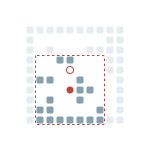

In [18]:
display(SVG(f'renders/render_{MODEL_NAME}.svg'))

### Tensorboard

In [25]:
%tensorboard --logdir tensorboard/dqn_baseline_PPO_A_1

ERROR: Failed to start
'/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages' (set by
the `TENSORBOARD_BINARY` environment variable): [Errno 13] Permission
denied: '/Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages'

In [28]:
!python3 /Users/wenyuxue/opt/anaconda3/lib/python3.9/site-packages/tensorboard/main.py --logdir tensorboard/dqn_baseline_PPO_A_1

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C
